In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'augmented-alzheimer-mri-dataset' dataset.
Path to dataset files: /kaggle/input/augmented-alzheimer-mri-dataset


# Alzheimer MRI Classification (PyTorch)

Multi-class classification with ROC-AUC and Grad-CAM

In [2]:

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

## Custom Dataset

In [9]:
from torch.utils.data import Dataset
from PIL import Image

class AlzheimerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "filepaths"]
        label = self.df.loc[idx, "label_id"]

        image = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        return image, label


## Transforms & Loaders

In [4]:
import os
import pandas as pd

MildDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/MildDemented'
ModerateDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/ModerateDemented'
NonDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/NonDemented'
VeryMildDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/VeryMildDemented'

filepaths = []
labels = []

dict_list = [
    MildDemented_dir,
    ModerateDemented_dir,
    NonDemented_dir,
    VeryMildDemented_dir
]

class_labels = [
    'Mild Demented',
    'Moderate Demented',
    'Non Demented',
    'Very MildDemented'
]

for i, j in enumerate(dict_list):
    for f in os.listdir(j):
        filepaths.append(os.path.join(j, f))
        labels.append(class_labels[i])

Alzheimer_df = pd.DataFrame({
    "filepaths": filepaths,
    "labels": labels
})

print(Alzheimer_df.head())
print(Alzheimer_df["labels"].value_counts())


                                           filepaths         labels
0  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
1  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
2  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
3  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
4  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
labels
Non Demented         9600
Mild Demented        8960
Very MildDemented    8960
Moderate Demented    6464
Name: count, dtype: int64


In [5]:
label_map = {
    'Mild Demented': 0,
    'Moderate Demented': 1,
    'Non Demented': 2,
    'Very MildDemented': 3
}

Alzheimer_df["label_id"] = Alzheimer_df["labels"].map(label_map)
num_classes = len(label_map)


In [6]:
from sklearn.model_selection import train_test_split

# First split: Train (70%) + Temp (30%)
train_df, temp_df = train_test_split(
    Alzheimer_df,
    test_size=0.30,
    stratify=Alzheimer_df["label_id"],
    random_state=42
)

# Second split: Validation (15%) + Test (15%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["label_id"],
    random_state=42
)

print("Train size:", len(train_df))
print("Val size:  ", len(val_df))
print("Test size: ", len(test_df))
print("Train distribution:\n", train_df["labels"].value_counts())
print("\nVal distribution:\n", val_df["labels"].value_counts())
print("\nTest distribution:\n", test_df["labels"].value_counts())


Train size: 23788
Val size:   5098
Test size:  5098
Train distribution:
 labels
Non Demented         6720
Very MildDemented    6272
Mild Demented        6272
Moderate Demented    4524
Name: count, dtype: int64

Val distribution:
 labels
Non Demented         1440
Mild Demented        1344
Very MildDemented    1344
Moderate Demented     970
Name: count, dtype: int64

Test distribution:
 labels
Non Demented         1440
Mild Demented        1344
Very MildDemented    1344
Moderate Demented     970
Name: count, dtype: int64


In [7]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [10]:
from torch.utils.data import DataLoader

train_dataset = AlzheimerDataset(train_df, train_transform)
val_dataset   = AlzheimerDataset(val_df, val_test_transform)
test_dataset  = AlzheimerDataset(test_df, val_test_transform)


train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [11]:
print(type(train_transform))


<class 'torchvision.transforms.transforms.Compose'>


In [12]:
def denormalize(images):
    mean = torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1)
    std = torch.tensor([0.5, 0.5, 0.5]).view(1, 3, 1, 1)
    return images * std + mean

print("Denormalize function defined.")

Denormalize function defined.


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_knee_images_pytorch(dataloader, class_names):
    images, labels = next(iter(dataloader))  # one batch

    images = denormalize(images)
    images = images.permute(0, 2, 3, 1)  # CHW → HWC

    batch_size = images.shape[0]
    r = min(batch_size, 25)

    plt.figure(figsize=(20, 20))

    for i in range(r):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        class_name = class_names[labels[i].item()]
        plt.title(class_name, color="green", fontsize=14)
        plt.axis("off")

    plt.show()


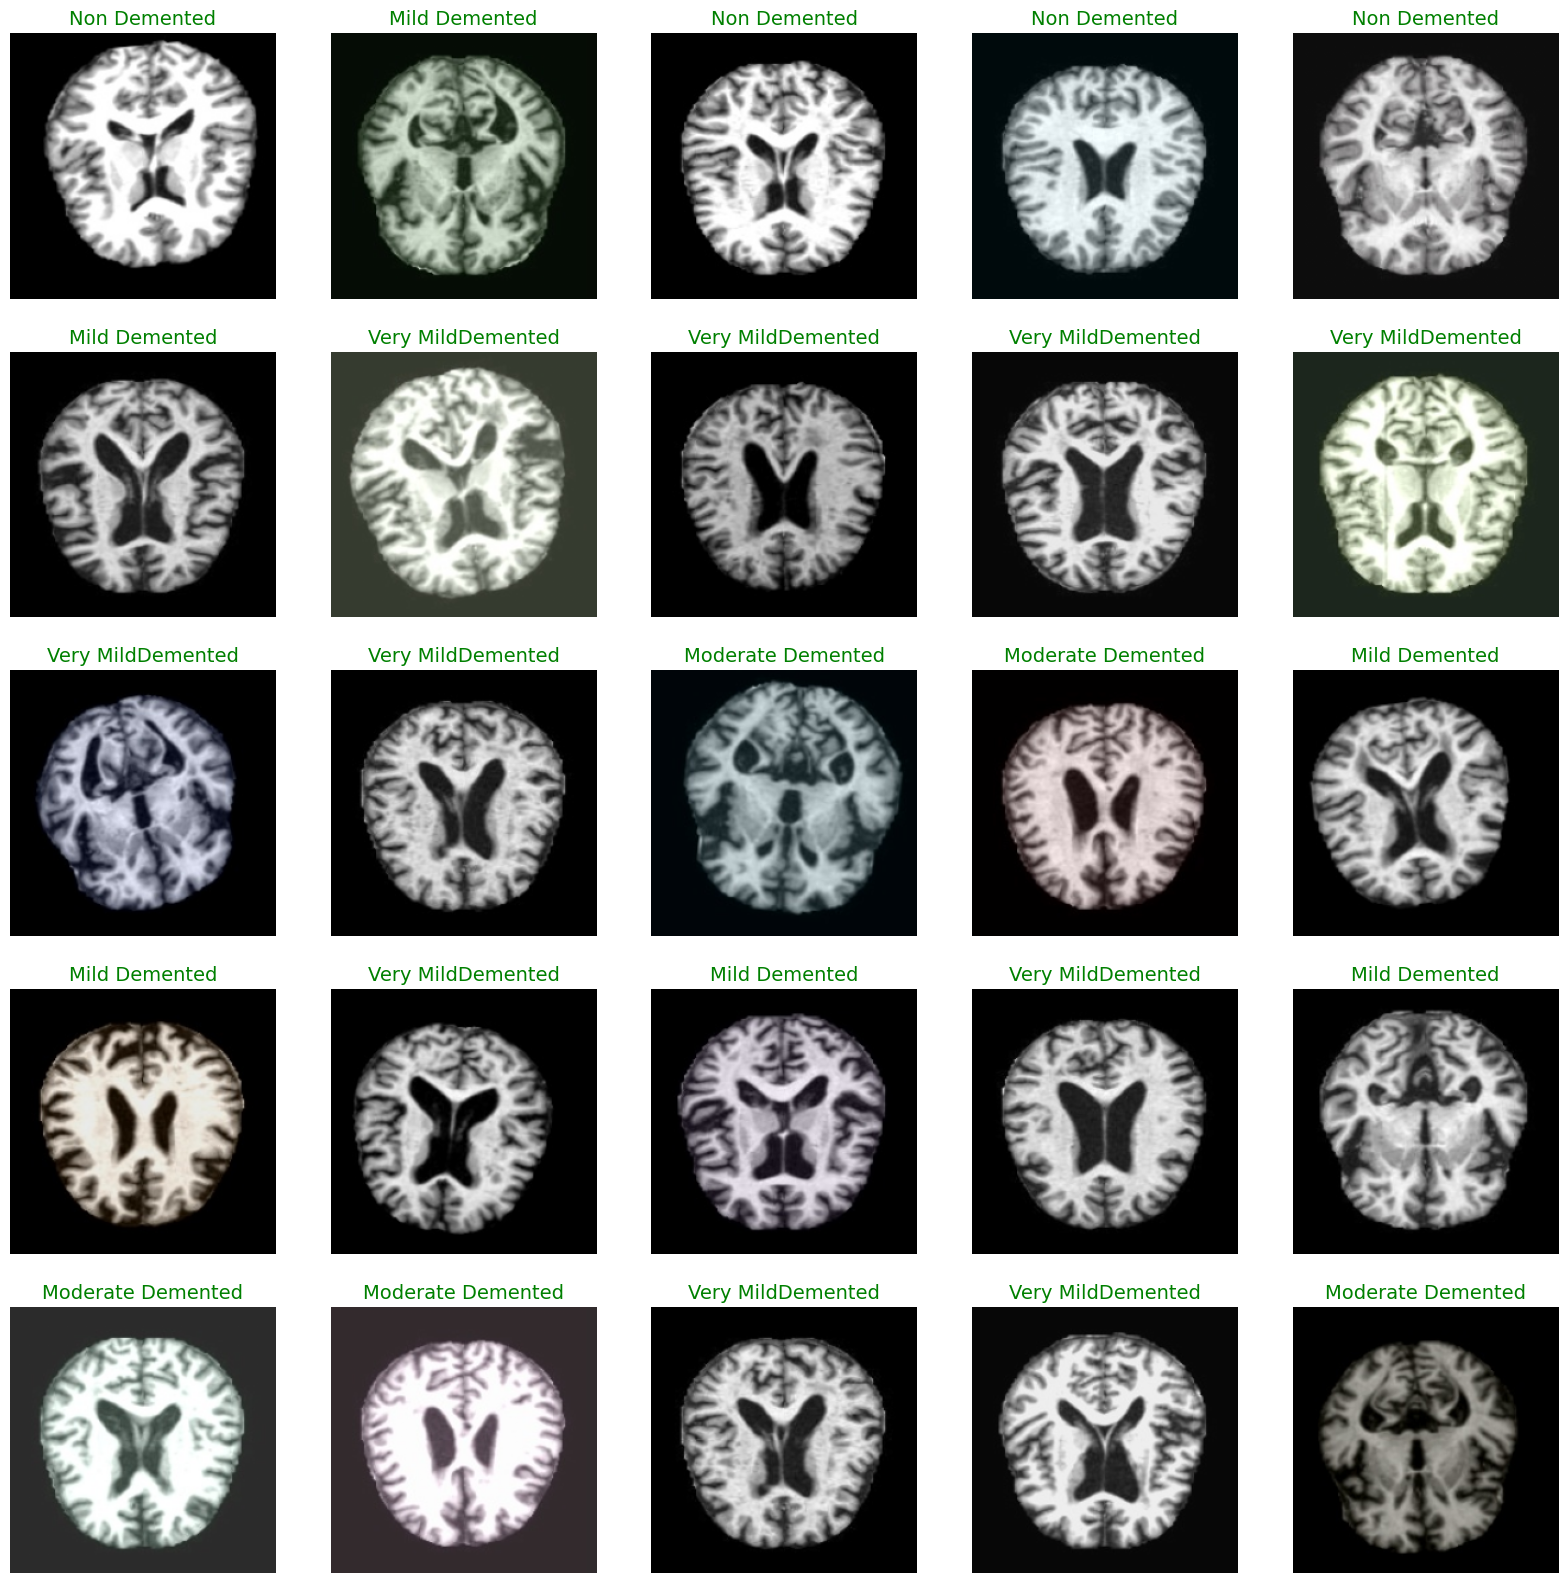

In [14]:
show_knee_images_pytorch(test_loader, class_labels)


## Model

In [16]:
import torch
import torch.nn as nn
import timm
class XceptionClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        # Base Xception model (ImageNet pretrained)
        self.base_model = timm.create_model(
            "xception",
            pretrained=True,
            num_classes=0,      # removes top classifier
            global_pool=""      # disable default pooling
        )

        self.pool = nn.AdaptiveMaxPool2d((1, 1))  # pooling='max'
        self.flatten = nn.Flatten()

        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(2048, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x


In [17]:
model = XceptionClassifier(num_classes=4)
model = model.to(device)
optimizer = torch.optim.Adamax(
    model.parameters(),
    lr=3e-4
)
criterion = nn.CrossEntropyLoss()


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


## Training Loop

In [22]:
from tqdm import tqdm

def train_epoch(model, loader):
    model.train()
    correct, total, loss_sum = 0, 0, 0

    pbar = tqdm(loader, desc="Training", leave=False)

    for x, y in pbar:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        preds = out.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

        pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc": f"{correct / total:.4f}"
        })

    return loss_sum / len(loader), correct / total
def eval_epoch(model, loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0
    y_true, y_pred = [], []

    pbar = tqdm(loader, desc="Validation", leave=False)

    with torch.no_grad():
        for x, y in pbar:
            x, y = x.to(device), y.to(device)

            out = model(x)
            loss = criterion(out, y)

            loss_sum += loss.item()
            preds = out.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

            y_true.extend(y.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())

            pbar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "acc": f"{correct / total:.4f}"
            })

    return loss_sum / len(loader), correct / total, y_true, y_pred


## Train

In [23]:
epochs = 10

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    train_loss, train_acc = train_epoch(model, train_loader)
    val_loss, val_acc, y_true, y_pred = eval_epoch(model, val_loader)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")



Epoch 1/10


Train Loss: 0.2613 | Train Acc: 0.8986
Val   Loss: 0.1161 | Val   Acc: 0.9561

Epoch 2/10


Train Loss: 0.1070 | Train Acc: 0.9615
Val   Loss: 0.0454 | Val   Acc: 0.9835

Epoch 3/10


Train Loss: 0.0570 | Train Acc: 0.9794
Val   Loss: 0.0358 | Val   Acc: 0.9871

Epoch 4/10


Train Loss: 0.0398 | Train Acc: 0.9857
Val   Loss: 0.0242 | Val   Acc: 0.9902

Epoch 5/10


Train Loss: 0.0308 | Train Acc: 0.9897
Val   Loss: 0.0298 | Val   Acc: 0.9902

Epoch 6/10


Train Loss: 0.0246 | Train Acc: 0.9919
Val   Loss: 0.0137 | Val   Acc: 0.9947

Epoch 7/10


Train Loss: 0.0197 | Train Acc: 0.9937
Val   Loss: 0.0131 | Val   Acc: 0.9949

Epoch 8/10


Train Loss: 0.0153 | Train Acc: 0.9946
Val   Loss: 0.0120 | Val   Acc: 0.9963

Epoch 9/10


Train Loss: 0.0151 | Train Acc: 0.9949
Val   Loss: 0.0128 | Val   Acc: 0.9957

Epoch 10/10


Train Loss: 0.0127 | Train Acc: 0.9959
Val   Loss: 0.0081 | Val   Acc: 0.9967


## Confusion Matrix

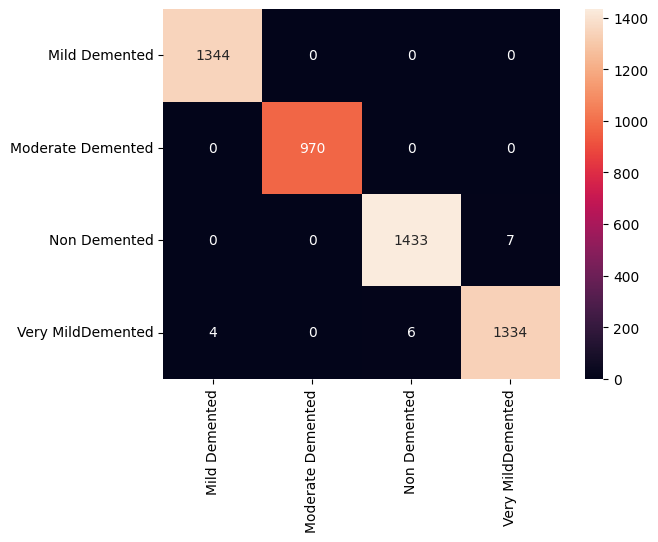

In [27]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.show()

## ROC-AUC (One-vs-Rest)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


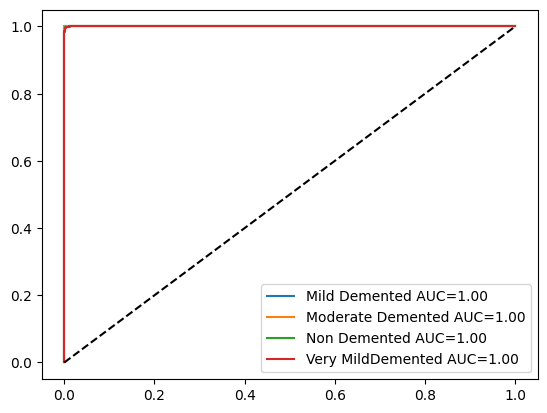

In [31]:

def get_probs(model, loader):
    model.eval()
    probs, labels = [], []
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            out = torch.softmax(model(x), dim=1)
            probs.append(out.cpu().numpy())
            labels.append(y.numpy())
    return np.vstack(probs), np.hstack(labels)

y_prob, y_true = get_probs(model, val_loader)
y_bin = label_binarize(y_true, classes=list(range(num_classes)))

for i,c in enumerate(class_labels):
    fpr,tpr,_ = roc_curve(y_bin[:,i], y_prob[:,i])
    plt.plot(fpr,tpr,label=f"{c} AUC={auc(fpr,tpr):.2f}")
plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.show()


In [29]:
import torch

# Define the path to save the model
model_save_path = "xception_alzheimer_classifier.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model saved successfully to {model_save_path}")

Model saved successfully to xception_alzheimer_classifier.pth


### ***=> GradCam***

In [ ]:
class GradCAM:
    def __init__(self, model, layer):
        self.model = model
        self.grad = None
        self.act = None

        layer.register_forward_hook(self._forward_hook)
        layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        self.act = out

    def _backward_hook(self, module, grad_in, grad_out):
        self.grad = grad_out[0]

    def generate(self, x):
        self.model.zero_grad()
        out = self.model(x)

        class_idx = out.argmax(dim=1)
        out[:, class_idx].backward()

        weights = self.grad.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.act).sum(dim=1)

        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam


In [ ]:
def denormalize(x):
    return x * 0.5 + 0.5


In [ ]:
def save_and_display_gradcam(
    img_tensor,
    cam_tensor,
    cam_path="cam.jpg",
    alpha=0.6
):
    """
    img_tensor: torch.Tensor (3, H, W)  - normalized image
    cam_tensor: torch.Tensor (H, W)     - Grad-CAM heatmap
    """

    # -----------------------------
    # 1. Detach & move to CPU
    # -----------------------------
    img = img_tensor.detach().cpu()
    cam = cam_tensor.detach().cpu()

    # -----------------------------
    # 2. Denormalize image
    # (assuming mean=0.5, std=0.5)
    # -----------------------------
    img = img * 0.5 + 0.5
    img = img.permute(1, 2, 0).numpy()   # HWC

    # -----------------------------
    # 3. Normalize CAM to [0, 255]
    # -----------------------------
    cam = cam.numpy()
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)
    cam = np.uint8(255 * cam)

    # -----------------------------
    # 4. Apply JET colormap
    # -----------------------------
    jet = cm.get_cmap("jet")
    jet_heatmap = jet(cam)[:, :, :3]     # RGB only
    jet_heatmap = np.uint8(255 * jet_heatmap)

    # -----------------------------
    # 5. Resize heatmap to image size
    # -----------------------------
    jet_heatmap = Image.fromarray(jet_heatmap)
    jet_heatmap = jet_heatmap.resize(
        (img.shape[1], img.shape[0])
    )
    jet_heatmap = np.array(jet_heatmap)

    # -----------------------------
    # 6. Superimpose heatmap
    # -----------------------------
    superimposed_img = (
        jet_heatmap * alpha + img * 255
    )
    superimposed_img = np.uint8(superimposed_img)

    # -----------------------------
    # 7. Save image
    # -----------------------------
    superimposed_img = Image.fromarray(superimposed_img)
    superimposed_img.save(cam_path)

    # -----------------------------
    # 8. Display
    # -----------------------------
    plt.figure(figsize=(5, 5))
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.show()

    return superimposed_img


In [ ]:
class_indices = {class_name: [] for class_name in class_labels}
for i, (_, label_id) in enumerate(val_dataset):
    class_indices[class_labels[label_id]].append(i)


requested_classes = ['Mild Demented', 'Very MildDemented', 'Moderate Demented']
selected_indices = []
for cls in requested_classes:

    selected_indices.extend(class_indices[cls][:3])


indices = selected_indices[:9]

print(f"Selected {len(indices)} indices for display.")

Selected 9 indices for display.


/tmp/ipython-input-2740007095.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


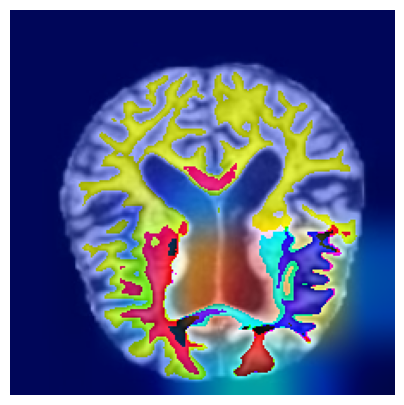

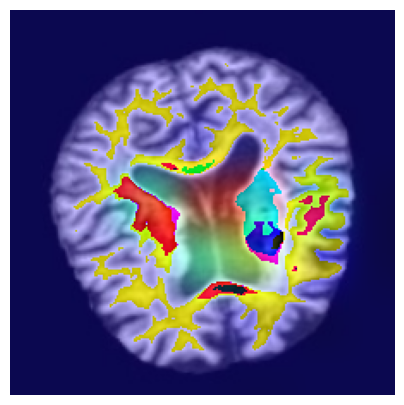

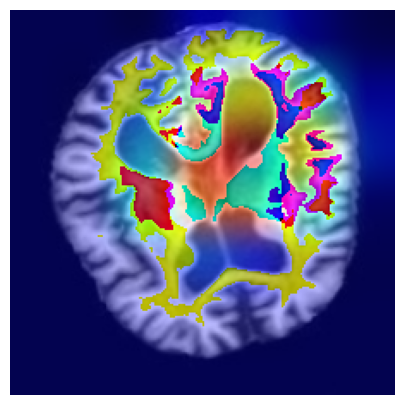

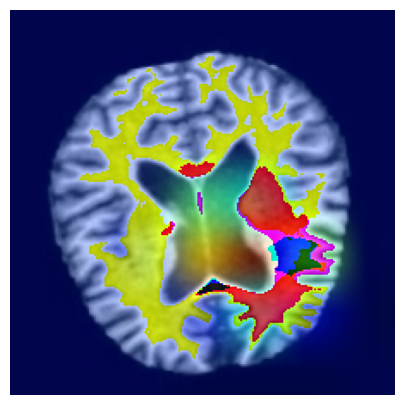

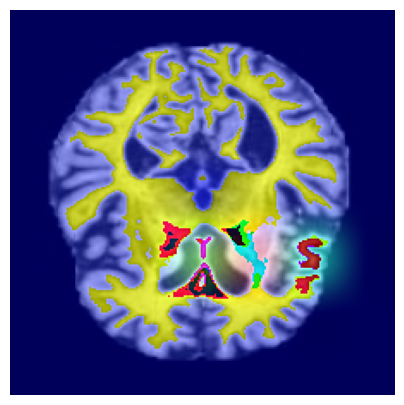

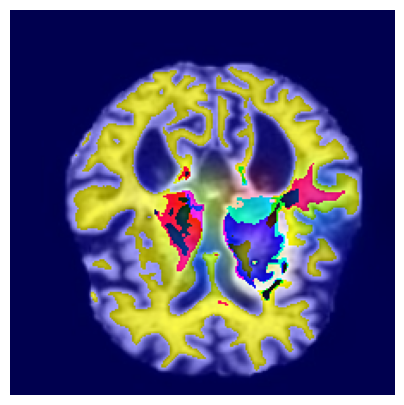

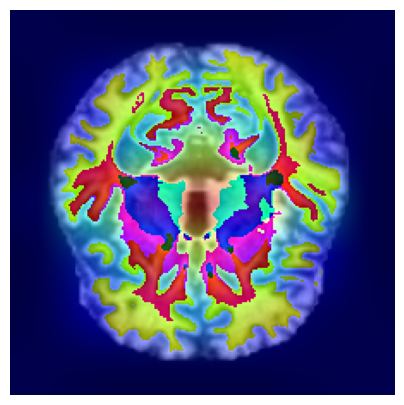

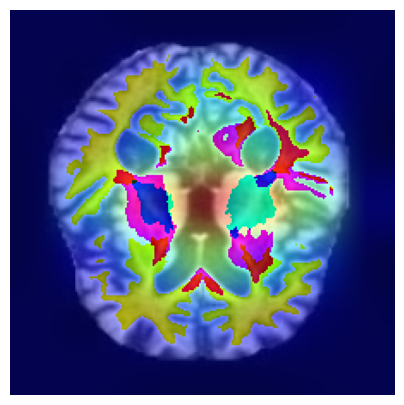

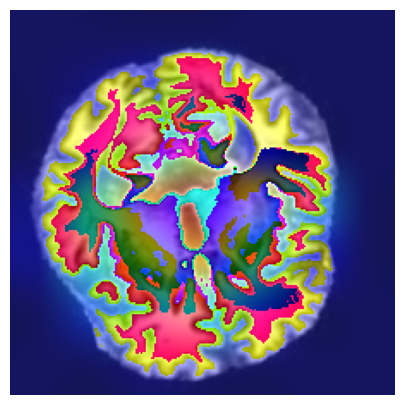

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import matplotlib.cm as cm # Added this import

os.makedirs("gradcam_results", exist_ok=True)

loaded_model.eval()
gc = GradCAM(loaded_model, loaded_model.base_model.conv4)

results = []

for idx in indices:
    img, label = val_dataset[idx]
    img_input = img.unsqueeze(0).to(device)

    with torch.no_grad():
        pred_idx = loaded_model(img_input).argmax(1).item()

    true_lbl = class_labels[label]
    pred_lbl = class_labels[pred_idx]

    cam = gc.generate(img_input)

    cam_path = f"gradcam_results/gradcam_{idx}.jpg"

    save_and_display_gradcam(
        img_tensor=img,
        cam_tensor=cam[0],
        cam_path=cam_path,
        alpha=0.6
    )


    results.append((cam_path, true_lbl, pred_lbl))

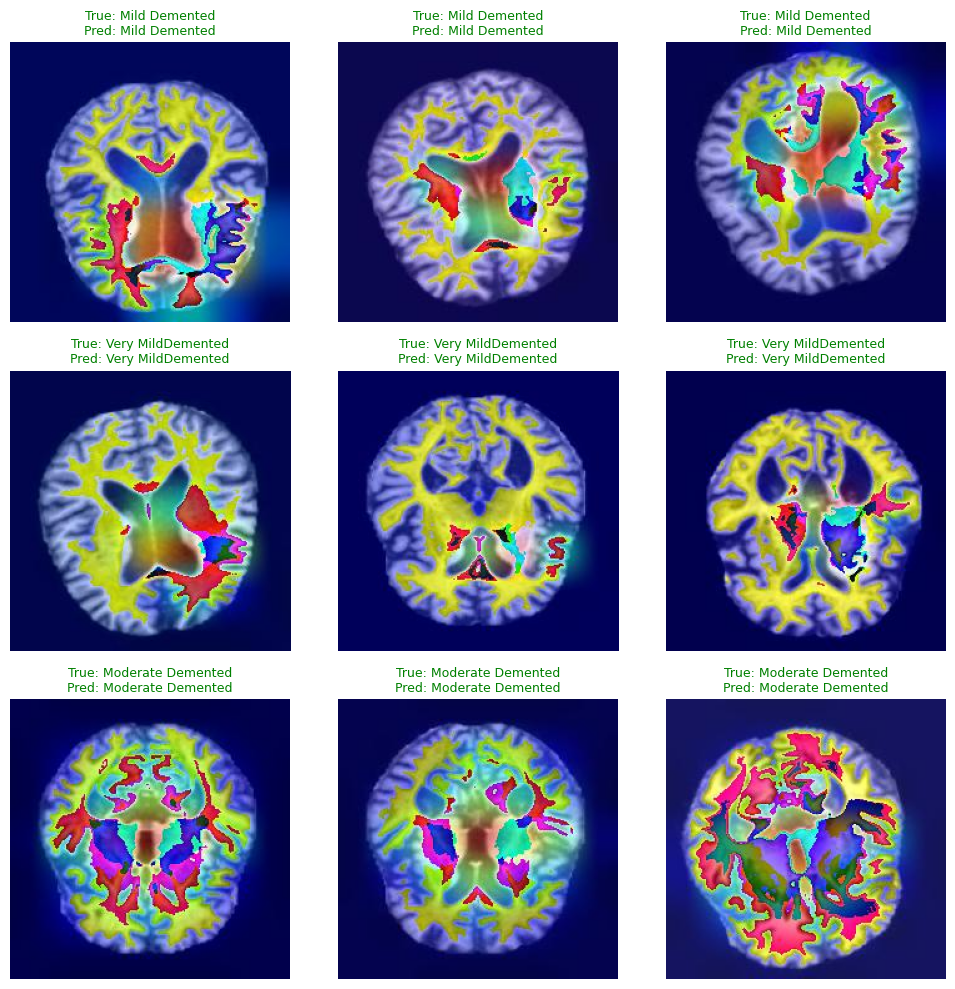

In [ ]:
plt.figure(figsize=(10, 10))


num_images_to_display = min(9, len(results))

for i in range(num_images_to_display):
    path, true_lbl, pred_lbl = results[i]

    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(Image.open(path))

    ax.set_title(
        f"True: {true_lbl}\nPred: {pred_lbl}",
        fontsize=9,
        color="green" if true_lbl == pred_lbl else "red"
    )

    ax.axis("off")

plt.tight_layout()
plt.show()